In [ ]:
!pip install numpy==1.26.4

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/proyectoint/'



df = pd.read_parquet(ruta + "ss2kc.parquet")

Mounted at /content/drive


In [3]:
df.shape

(12705, 4)

In [4]:
# add column to df that is 1 if theres is a 1 in the labels list or 0 if not
df['existeK'] = df['labels'].apply(lambda x: 1 if 1 in x else 0)


In [5]:
df.head()

,subject_id,signal,init_sec,labels,existeK
0,01-02-0001,"[0.8642647230320131, -1.3254061324679178, -2.0...",1280.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,01-02-0001,"[19.979204735578016, 24.564032163729603, 27.49...",1300.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,01-02-0001,"[-0.6234027275576637, 1.0729096011331865, 2.46...",1320.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,01-02-0001,"[1.52619980314834, 3.8336439275996477, 5.85130...",1340.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,01-02-0001,"[2.417046285089186, 1.2075578435732488, -0.733...",1360.76108,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [6]:
# cuenta cuantos 1 hay en existe K y cuantos 0
df['existeK'].value_counts()

,count
existeK,
1,6374
0,6331


hay 12705 señales donde 6331 no presentan complejo K y 6374 en las que si hay.

# CNN para solo detectar si existe complejo K en la señal

In [7]:
class CNNDETECTAR(nn.Module):
    """
    A CRNN (Convolutional Recurrent Neural Network) model based on the provided architecture diagram.
    This model processes a time-series signal to perform classification at each time step
    of the downsampled sequence.
    """
    def __init__(self, in_channels=1, Nf=32, N1=128, N2=128, p1=0.5, p2=0.5): # num_classes removed
        """
        Initializes the model layers.
        """
        super(CNNDETECTAR, self).__init__()

        # --- Convolutional Feature Extractor ---
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=Nf, out_channels=Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=Nf, out_channels=2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=2*Nf, out_channels=2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=2*Nf, out_channels=4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=4*Nf, out_channels=4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # --- Dropout Layers ---
        self.dropout1 = nn.Dropout(p=p1)
        self.dropout2 = nn.Dropout(p=p2)

        # --- Recurrent Blocks (Bidirectional LSTMs) ---
        self.blstm1 = nn.LSTM(input_size=4*Nf, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)
        self.blstm2 = nn.LSTM(input_size=2*N1, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)

        # --- Classifier ---
        # CHANGE 1: The final layer now outputs 1 channel for binary classification.
        self.classifier = nn.Sequential(
            nn.Conv1d(in_channels=2*N1, out_channels=N2, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=N2, out_channels=1, kernel_size=1) # Changed num_classes to 1
        )

    def forward(self, x):
        """
        Defines the forward pass of the network.
        """
        # Pass through convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Reshape for LSTMs
        x = x.permute(0, 2, 1)

        # Pass through recurrent blocks
        x = self.dropout1(x)
        x, _ = self.blstm1(x)
        x = self.dropout2(x)
        x, _ = self.blstm2(x)
        x = self.dropout2(x)

        # Reshape for 1x1 Convs
        x = x.permute(0, 2, 1)

        # Pass through the classifier
        logits_seq = self.classifier(x) # -> Shape is now (batch_size, 1, 500)

        # CHANGE 2: Add Global Average Pooling to collapse the time dimension.
        # This takes the mean of the 500 time steps to get a single prediction.
        logits = torch.mean(logits_seq, dim=2) # -> Shape becomes (batch_size, 1)

        return logits

In [8]:
# Configurar el dispositivo (usar GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [9]:
# df_detectar solo debe tener las columnas signal y existeK
df_detectar = df[['signal', 'existeK']]

In [10]:
# División de datos: 80% entrenamiento, 10% validación, 10% prueba
# Primero, separamos el conjunto de entrenamiento del resto
train_df, temp_df = train_test_split(
    df_detectar, test_size=0.2, random_state=42, stratify=df_detectar['existeK']
)
# Luego, dividimos el resto en validación y prueba
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['existeK']
)

print(f"\nTamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")




Tamaño del conjunto de entrenamiento: 10164
Tamaño del conjunto de validación: 1270
Tamaño del conjunto de prueba: 1271


In [11]:
# --- 3. DATASETS Y DATALOADERS DE PYTORCH ---

class SignalDataset(Dataset):
    """Custom Dataset for loading signals and labels."""
    def __init__(self, dataframe):
        self.signals = torch.tensor(np.array(dataframe['signal'].tolist()), dtype=torch.float32)
        self.labels = torch.tensor(dataframe['existeK'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # CORRECTED COMMENT: Add a "channel" dimension for the CNN (4000) -> (1, 4000)
        signal = self.signals[idx].unsqueeze(0)
        label = self.labels[idx].unsqueeze(0)
        return signal, label

BATCH_SIZE = 64

# Crear instancias de Dataset
train_dataset = SignalDataset(train_df)
val_dataset = SignalDataset(val_df)
test_dataset = SignalDataset(test_df)

# Crear instancias de DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 4. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN ---

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Función para entrenar el modelo durante una época."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Función para evaluar el modelo en un conjunto de datos."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc





In [12]:
# --- 5. CICLO PRINCIPAL DE ENTRENAMIENTO (CON EARLY STOPPING) ---

# Hiperparámetros
EPOCHS = 30
LEARNING_RATE = 0.001

# --- Early Stopping Parameters ---
patience = 10  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value

# Instanciar modelo, función de pérdida y optimizador
model = CNNDETECTAR().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Almacenar historial para graficar
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\n--- Iniciando Entrenamiento ---")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Época {epoch+1}/{EPOCHS} | "
          f"Loss de entrenamiento: {train_loss:.4f} | Acc de entrenamiento: {train_acc:.4f} | "
          f"Loss de validación: {val_loss:.4f} | Acc de validación: {val_acc:.4f}")

    # --- Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optional: Save the best model here
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n--- Early stopping en la época {epoch+1} ---")
        break # Exit the training loop

print("--- Entrenamiento Finalizado ---")


--- Iniciando Entrenamiento ---
Época 1/30 | Loss de entrenamiento: 0.6953 | Acc de entrenamiento: 0.6478 | Loss de validación: 0.5176 | Acc de validación: 0.7724
Época 2/30 | Loss de entrenamiento: 0.4152 | Acc de entrenamiento: 0.8220 | Loss de validación: 0.3227 | Acc de validación: 0.8598
Época 3/30 | Loss de entrenamiento: 0.3343 | Acc de entrenamiento: 0.8580 | Loss de validación: 0.2835 | Acc de validación: 0.8732
Época 4/30 | Loss de entrenamiento: 0.3286 | Acc de entrenamiento: 0.8578 | Loss de validación: 0.3024 | Acc de validación: 0.8795
Época 5/30 | Loss de entrenamiento: 0.3169 | Acc de entrenamiento: 0.8606 | Loss de validación: 0.2824 | Acc de validación: 0.8732
Época 6/30 | Loss de entrenamiento: 0.2886 | Acc de entrenamiento: 0.8762 | Loss de validación: 0.2785 | Acc de validación: 0.8772
Época 7/30 | Loss de entrenamiento: 0.2739 | Acc de entrenamiento: 0.8820 | Loss de validación: 0.2393 | Acc de validación: 0.9047
Época 8/30 | Loss de entrenamiento: 0.2600 | Acc d

KeyboardInterrupt: 


--- Evaluando en el conjunto de prueba ---
Accuracy en prueba: 0.9142
Precision en prueba: 0.9139
Recall en prueba: 0.9154
F1-Score en prueba: 0.9146


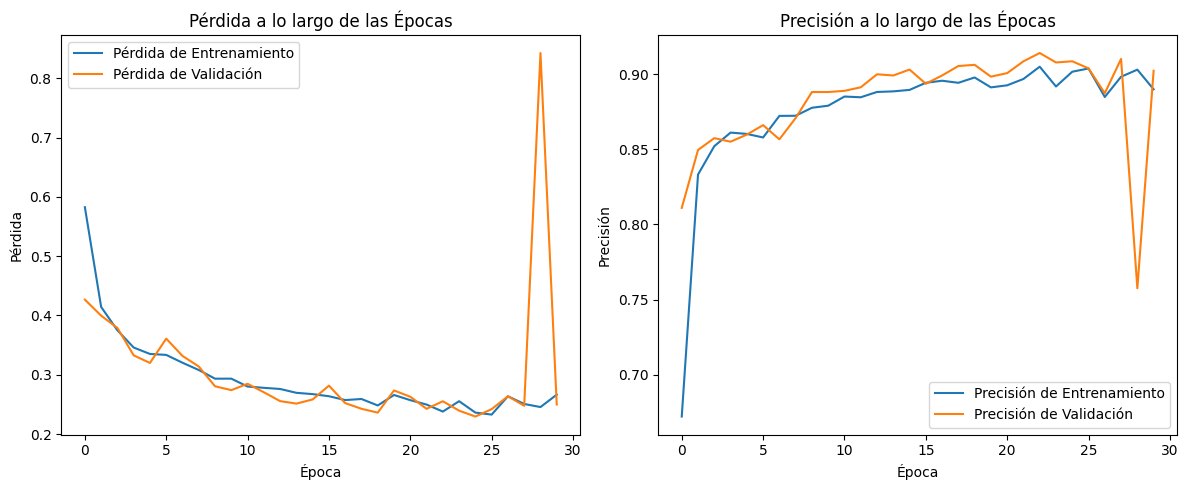

In [ ]:
# --- 6. EVALUACIÓN FINAL Y VISUALIZACIÓN ---

print("\n--- Evaluando en el conjunto de prueba ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().flatten())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy en prueba: {accuracy:.4f}")
print(f"Precision en prueba: {precision:.4f}")
print(f"Recall en prueba: {recall:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

# Graficar resultados del entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history['val_acc'], label='Precisión de Validación')
plt.title('Precisión a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

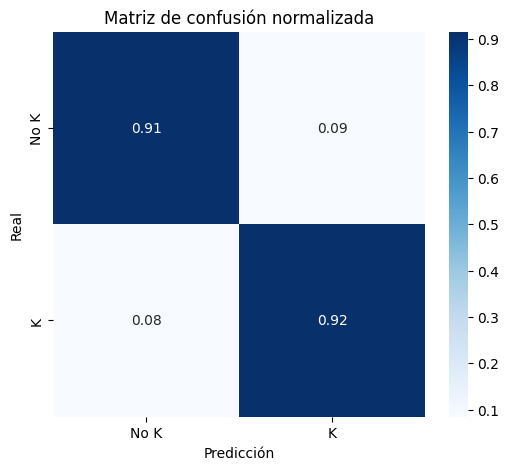

In [ ]:
def plot_confusion_matrix(model, dataloader, device, title="Matriz de confusión normalizada"):
    """
    Evalúa el modelo en el dataloader y grafica la matriz de confusión binaria normalizada.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # --- CAMBIO 1: Normalizar la matriz por las filas (clases reales) ---
    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    # Graficar
    plt.figure(figsize=(6, 5))
    # --- CAMBIO 2: Cambiar el formato para mostrar decimales ---
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No K", "K"], yticklabels=["No K", "K"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Ejemplo de uso
plot_confusion_matrix(model, test_loader, device)


### 5 Entrenamientos

In [13]:
# --- 5. CICLO PRINCIPAL PARA MÚLTIPLES ENTRENAMIENTOS ---

NUM_RUNS = 5  # Número de veces que quieres entrenar el modelo
all_histories = [] # Lista para guardar los resultados de cada entrenamiento

for i in range(NUM_RUNS):
    print(f"\\n--- Iniciando Corrida de Entrenamiento {i+1}/{NUM_RUNS} ---\\n")

    # --- Hiperparámetros ---
    EPOCHS = 40 # Usaré 40 como en tu gráfico de ejemplo
    LEARNING_RATE = 0.0001
    patience = 10
    patience_counter = 0
    best_val_loss = float('inf')

    # --- ¡Importante! Reiniciar el modelo y el optimizador en cada corrida ---
    model = CNNDETECTAR().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Almacenar historial para la corrida actual
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # --- Bucle de entrenamiento para una corrida ---
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Corrida {i+1}, Época {epoch+1}/{EPOCHS} | "
              f"Loss ent: {train_loss:.4f} | Acc ent: {train_acc:.4f} | "
              f"Loss val: {val_loss:.4f} | Acc val: {val_acc:.4f}")

        # Lógica de Early Stopping (opcional, pero buena práctica)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"--- Early stopping en la época {epoch+1} ---")
            break

    # Guardar el historial de esta corrida en la lista principal
    all_histories.append(history)

print("\\n--- Todas las corridas de entrenamiento han finalizado ---")

\n--- Iniciando Corrida de Entrenamiento 1/5 ---\n
Corrida 1, Época 1/40 | Loss ent: 0.5825 | Acc ent: 0.6784 | Loss val: 0.4206 | Acc val: 0.8402
Corrida 1, Época 2/40 | Loss ent: 0.4023 | Acc ent: 0.8440 | Loss val: 0.3727 | Acc val: 0.8622
Corrida 1, Época 3/40 | Loss ent: 0.3663 | Acc ent: 0.8550 | Loss val: 0.3379 | Acc val: 0.8559
Corrida 1, Época 4/40 | Loss ent: 0.3506 | Acc ent: 0.8589 | Loss val: 0.3239 | Acc val: 0.8598
Corrida 1, Época 5/40 | Loss ent: 0.3408 | Acc ent: 0.8610 | Loss val: 0.3199 | Acc val: 0.8591
Corrida 1, Época 6/40 | Loss ent: 0.3257 | Acc ent: 0.8661 | Loss val: 0.3278 | Acc val: 0.8677
Corrida 1, Época 7/40 | Loss ent: 0.3168 | Acc ent: 0.8670 | Loss val: 0.2898 | Acc val: 0.8850
Corrida 1, Época 8/40 | Loss ent: 0.3021 | Acc ent: 0.8766 | Loss val: 0.2822 | Acc val: 0.8850
Corrida 1, Época 9/40 | Loss ent: 0.2887 | Acc ent: 0.8816 | Loss val: 0.2622 | Acc val: 0.8976
Corrida 1, Época 10/40 | Loss ent: 0.2905 | Acc ent: 0.8786 | Loss val: 0.2847 | Acc 

<Figure size 1500x600 with 0 Axes>

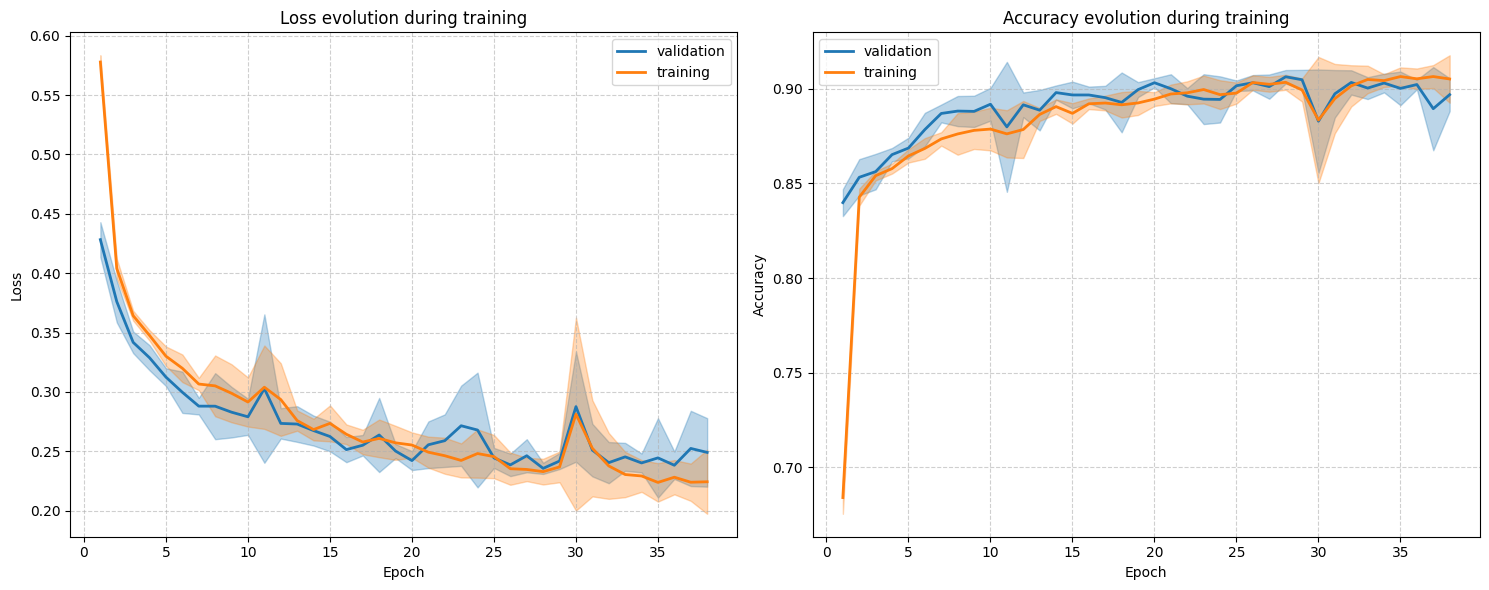

In [14]:
# --- NUEVO CÓDIGO PARA MANEJAR LONGITUDES DIFERENTES ---
# 1. Encontrar la longitud de la corrida más corta debido al early stopping
min_epochs = min([len(h['train_loss']) for h in all_histories])

# 2. Truncar todas las listas de historial a esa longitud mínima
train_loss_all = np.array([h['train_loss'][:min_epochs] for h in all_histories])
val_loss_all = np.array([h['val_loss'][:min_epochs] for h in all_histories])
train_acc_all = np.array([h['train_acc'][:min_epochs] for h in all_histories])
val_acc_all = np.array([h['val_acc'][:min_epochs] for h in all_histories])
# --- FIN DE LA CORRECCIÓN ---

# Calcular promedio (mean) y desviación estándar (std) a lo largo de las corridas (axis=0)
mean_train_loss = np.mean(train_loss_all, axis=0)
std_train_loss = np.std(train_loss_all, axis=0)

mean_val_loss = np.mean(val_loss_all, axis=0)
std_val_loss = np.std(val_loss_all, axis=0)

mean_train_acc = np.mean(train_acc_all, axis=0)
std_train_acc = np.std(train_acc_all, axis=0)

mean_val_acc = np.mean(val_acc_all, axis=0)
std_val_acc = np.std(val_acc_all, axis=0)

# El resto de tu código de graficación funcionará perfectamente con esto.
# Eje X para los gráficos (número de épocas)
epochs_range = range(1, len(mean_train_loss) + 1)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# (El resto de tu código para plt.plot y plt.fill_between va aquí y no necesita cambios)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
# Curva de validación
plt.plot(epochs_range, mean_val_loss, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.3)
# Curva de entrenamiento
plt.plot(epochs_range, mean_train_loss, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.3)
plt.title('Loss evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
# Curva de validación
plt.plot(epochs_range, mean_val_acc, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:blue', alpha=0.3)
# Curva de entrenamiento
plt.plot(epochs_range, mean_train_acc, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:orange', alpha=0.3)
plt.title('Accuracy evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

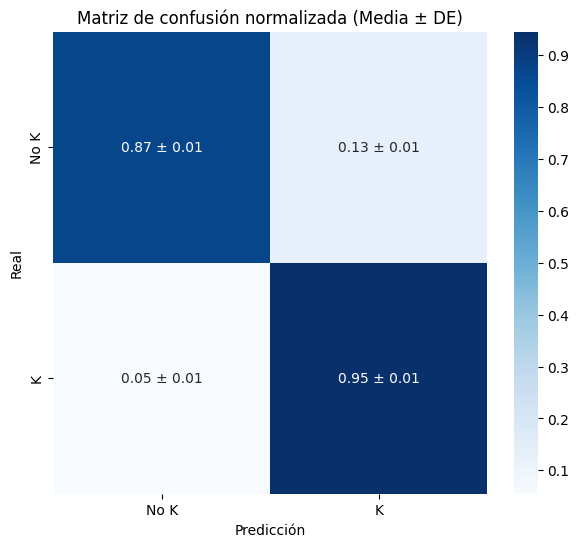

In [17]:
from sklearn.utils import resample
def plot_confusion_matrix_with_std(model, dataloader, device,
                                   n_bootstraps=1000,
                                   title="Matriz de confusión normalizada (Media ± DE)"):
    """
    Evalúa el modelo usando bootstrapping para calcular la media y DE
    de la matriz de confusión normalizada.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # 1. Obtener todas las predicciones y etiquetas una sola vez
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # 2. Realizar el bootstrapping
    bootstrapped_cms = []
    for _ in range(n_bootstraps):
        # Remuestrear los índices
        indices = resample(range(len(all_preds)))
        boot_labels = all_labels[indices]
        boot_preds = all_preds[indices]

        # Calcular la matriz de confusión para esta muestra
        cm = confusion_matrix(boot_labels, boot_preds, normalize='true')

        # Asegurarse de que la matriz sea 2x2 (en caso de que una muestra no tenga una clase)
        if cm.shape == (1, 1):
            if boot_labels[0] == 0:
                cm = np.array([[cm[0,0], 0], [0, 0]])
            else: # Si solo vio '1' y acertó '1':
                cm = np.array([[0, 0], [0, cm[0,0]]])

        bootstrapped_cms.append(cm)

    # 3. Calcular la media y la desviación estándar
    bootstrapped_cms = np.array(bootstrapped_cms)

    cm_mean = np.mean(bootstrapped_cms, axis=0) # Media a través de las muestras
    cm_std = np.std(bootstrapped_cms, axis=0)   # Desviación estándar a través de las muestras

    # 4. Crear las etiquetas de texto (anotaciones)
    annot_labels = np.empty_like(cm_mean, dtype=object)
    for i in range(cm_mean.shape[0]):
        for j in range(cm_mean.shape[1]):
            mean_val = cm_mean[i, j]
            std_val = cm_std[i, j]
            # FORMATO: "0.85 ± 0.02"
            annot_labels[i, j] = f"{mean_val:.2f} ± {std_val:.2f}"

    # 5. Graficar
    plt.figure(figsize=(7, 6)) # Un poco más grande para el texto

    # Usamos cm_mean para el COLOR
    # Usamos annot_labels para el TEXTO
    # Usamos fmt="" porque las etiquetas ya están formateadas
    sns.heatmap(cm_mean,
                annot=annot_labels,  # <--- Anotaciones personalizadas
                fmt="",                # <--- Formato vacío
                cmap="Blues",
                xticklabels=["No K", "K"],
                yticklabels=["No K", "K"])

    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Ejemplo de uso (AHORA LLAMA A LA NUEVA FUNCIÓN)
plot_confusion_matrix_with_std(model, test_loader, device)

### Probando con MLP

In [18]:
class CNNDETECTAR_MLP(nn.Module):
    """
    Modelo CRNN con un clasificador MLP final para la tarea de detección.
    """
    def __init__(self, in_channels=1, Nf=32, N1=128, N2=128, p1=0.5, p2=0.5):
        super(CNNDETECTAR_MLP, self).__init__()

        # --- Extractor de Características Convolucional (Sin cambios) ---
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=Nf, out_channels=Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=Nf, out_channels=2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=2*Nf, out_channels=2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=2*Nf, out_channels=4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=4*Nf, out_channels=4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # --- Capas de Dropout (Sin cambios) ---
        self.dropout1 = nn.Dropout(p=p1)
        self.dropout2 = nn.Dropout(p=p2)

        # --- Bloques Recurrentes (Bi-LSTM, Sin cambios) ---
        self.blstm1 = nn.LSTM(input_size=4*Nf, hidden_size=N1, batch_first=True, bidirectional=True)
        self.blstm2 = nn.LSTM(input_size=2*N1, hidden_size=N1, batch_first=True, bidirectional=True)

        # --- CAMBIO 1: Reemplazar el clasificador CNN con un MLP ---
        # El MLP operará sobre las características de cada paso de tiempo (2*N1 de la Bi-LSTM).
        self.classifier_mlp = nn.Sequential(
            nn.Linear(in_features=2*N1, out_features=N2),
            nn.ReLU(),
            nn.Linear(in_features=N2, out_features=1) # Salida de 1 para clasificación binaria
        )

    def forward(self, x):
        """
        Define el forward pass con el nuevo clasificador MLP.
        """
        # Bloques convolucionales (Sin cambios)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Reshape para LSTMs (Sin cambios)
        x = x.permute(0, 2, 1) # Shape -> (batch_size, 500, features)

        # Bloques recurrentes (Sin cambios)
        x = self.dropout1(x)
        x, _ = self.blstm1(x)
        x = self.dropout2(x)
        x, _ = self.blstm2(x)
        x = self.dropout2(x)
        # Shape de salida de la LSTM -> (batch_size, 500, 2*N1)

        # --- CAMBIO 2: Pasar a través del MLP y promediar ---
        # Ya no necesitamos permutar las dimensiones para la CNN.
        # Pasamos la salida de la LSTM directamente al MLP.
        logits_seq = self.classifier_mlp(x) # Shape -> (batch_size, 500, 1)

        # El Global Average Pooling sigue siendo necesario para obtener una predicción por señal.
        # Promediamos a lo largo de la dimensión de la secuencia (dim=1).
        logits = torch.mean(logits_seq, dim=1) # Shape -> (batch_size, 1)

        return logits

In [19]:
# --- 5. CICLO PRINCIPAL DE ENTRENAMIENTO (CON EARLY STOPPING) ---

# Haz esto una vez antes de tu bucle de entrenamiento
# Concatena todas las etiquetas para calcular la proporción
all_labels_tensor = torch.cat([labels for _, labels in train_loader], dim=0)

# Calcula cuántos puntos son "No K" (0) y cuántos son "K" (1)
neg_count = (all_labels_tensor == 0).sum()
pos_count = (all_labels_tensor == 1).sum()

# El peso es la relación entre negativos y positivos
pos_weight = neg_count / pos_count

print(f"Peso positivo calculado: {pos_weight:.2f}")

# Hiperparámetros
EPOCHS = 30
LEARNING_RATE = 0.0001

# --- Early Stopping Parameters ---
patience = 10  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value

# Instanciar modelo, función de pérdida y optimizador
model = CNNDETECTAR_MLP().to(device)
# Luego, en tu celda de entrenamiento, instancia el criterio con este peso
# Asegúrate de que el peso sea un tensor y esté en el dispositivo correcto (GPU/CPU)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Almacenar historial para graficar
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}


print("\n--- Iniciando Entrenamiento ---")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Época {epoch+1}/{EPOCHS} | "
          f"Loss de entrenamiento: {train_loss:.4f} | Acc de entrenamiento: {train_acc:.4f} | "
          f"Loss de validación: {val_loss:.4f} | Acc de validación: {val_acc:.4f}")

    # --- Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optional: Save the best model here
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n--- Early stopping en la época {epoch+1} ---")
        break # Exit the training loop

print("--- Entrenamiento Finalizado ---")

Peso positivo calculado: 0.99

--- Iniciando Entrenamiento ---


KeyboardInterrupt: 


--- Evaluando en el conjunto de prueba ---
Accuracy en prueba: 0.9001
Precision en prueba: 0.8961
Recall en prueba: 0.9060
F1-Score en prueba: 0.9010


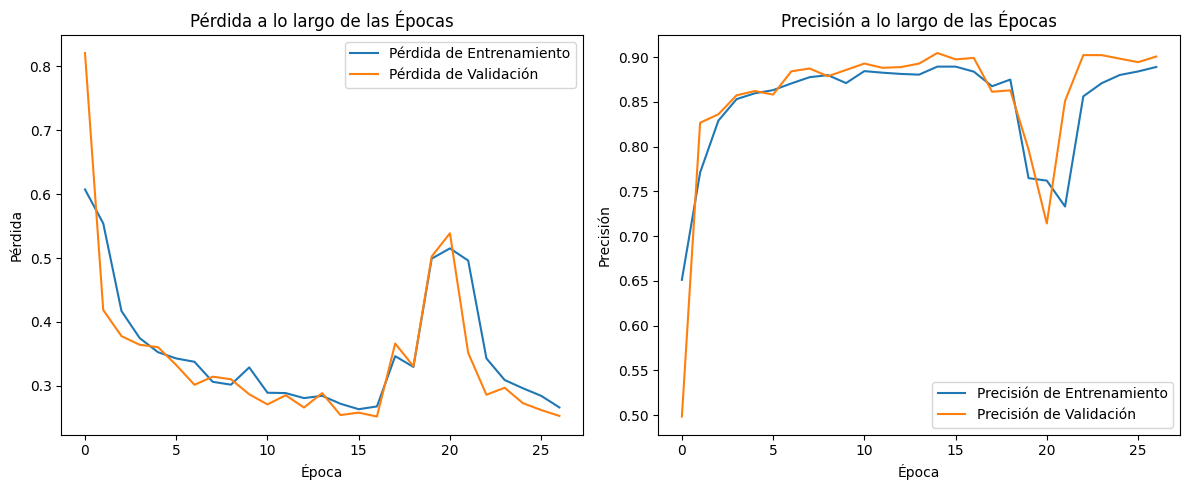

In [ ]:
# --- 6. EVALUACIÓN FINAL Y VISUALIZACIÓN ---

print("\n--- Evaluando en el conjunto de prueba ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().flatten())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy en prueba: {accuracy:.4f}")
print(f"Precision en prueba: {precision:.4f}")
print(f"Recall en prueba: {recall:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

# Graficar resultados del entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history['val_acc'], label='Precisión de Validación')
plt.title('Precisión a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

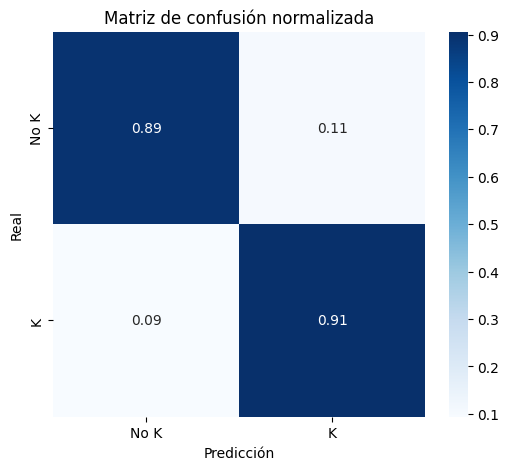

In [ ]:
def plot_confusion_matrix(model, dataloader, device, title="Matriz de confusión normalizada"):
    """
    Evalúa el modelo en el dataloader y grafica la matriz de confusión binaria normalizada.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # --- CAMBIO 1: Normalizar la matriz por las filas (clases reales) ---
    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    # Graficar
    plt.figure(figsize=(6, 5))
    # --- CAMBIO 2: Cambiar el formato para mostrar decimales ---
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No K", "K"], yticklabels=["No K", "K"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Ejemplo de uso
plot_confusion_matrix(model, test_loader, device)

##### 5 Entrenamientos MLP

In [20]:
# --- 5. CICLO PRINCIPAL PARA MÚLTIPLES ENTRENAMIENTOS ---

NUM_RUNS = 5  # Número de veces que quieres entrenar el modelo
all_histories = [] # Lista para guardar los resultados de cada entrenamiento

for i in range(NUM_RUNS):
    print(f"\\n--- Iniciando Corrida de Entrenamiento {i+1}/{NUM_RUNS} ---\\n")

    # --- Hiperparámetros ---
    EPOCHS = 40 # Usaré 40 como en tu gráfico de ejemplo
    LEARNING_RATE = 0.0001
    patience = 10
    patience_counter = 0
    best_val_loss = float('inf')

    # --- ¡Importante! Reiniciar el modelo y el optimizador en cada corrida ---
    model = CNNDETECTAR_MLP().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Almacenar historial para la corrida actual
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # --- Bucle de entrenamiento para una corrida ---
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Corrida {i+1}, Época {epoch+1}/{EPOCHS} | "
              f"Loss ent: {train_loss:.4f} | Acc ent: {train_acc:.4f} | "
              f"Loss val: {val_loss:.4f} | Acc val: {val_acc:.4f}")

        # Lógica de Early Stopping (opcional, pero buena práctica)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"--- Early stopping en la época {epoch+1} ---")
            break

    # Guardar el historial de esta corrida en la lista principal
    all_histories.append(history)

print("\\n--- Todas las corridas de entrenamiento han finalizado ---")

\n--- Iniciando Corrida de Entrenamiento 1/5 ---\n
Corrida 1, Época 1/40 | Loss ent: 0.5734 | Acc ent: 0.6871 | Loss val: 0.3994 | Acc val: 0.8433
Corrida 1, Época 2/40 | Loss ent: 0.4009 | Acc ent: 0.8421 | Loss val: 0.3990 | Acc val: 0.8583
Corrida 1, Época 3/40 | Loss ent: 0.3711 | Acc ent: 0.8507 | Loss val: 0.3643 | Acc val: 0.8677
Corrida 1, Época 4/40 | Loss ent: 0.3491 | Acc ent: 0.8538 | Loss val: 0.3866 | Acc val: 0.8701
Corrida 1, Época 5/40 | Loss ent: 0.3391 | Acc ent: 0.8594 | Loss val: 0.3095 | Acc val: 0.8732
Corrida 1, Época 6/40 | Loss ent: 0.3240 | Acc ent: 0.8646 | Loss val: 0.3511 | Acc val: 0.8354
Corrida 1, Época 7/40 | Loss ent: 0.3130 | Acc ent: 0.8719 | Loss val: 0.2974 | Acc val: 0.8669
Corrida 1, Época 8/40 | Loss ent: 0.3201 | Acc ent: 0.8731 | Loss val: 0.3084 | Acc val: 0.8732
Corrida 1, Época 9/40 | Loss ent: 0.3223 | Acc ent: 0.8656 | Loss val: 0.2984 | Acc val: 0.8850
Corrida 1, Época 10/40 | Loss ent: 0.2882 | Acc ent: 0.8836 | Loss val: 0.2984 | Acc 

<Figure size 1500x600 with 0 Axes>

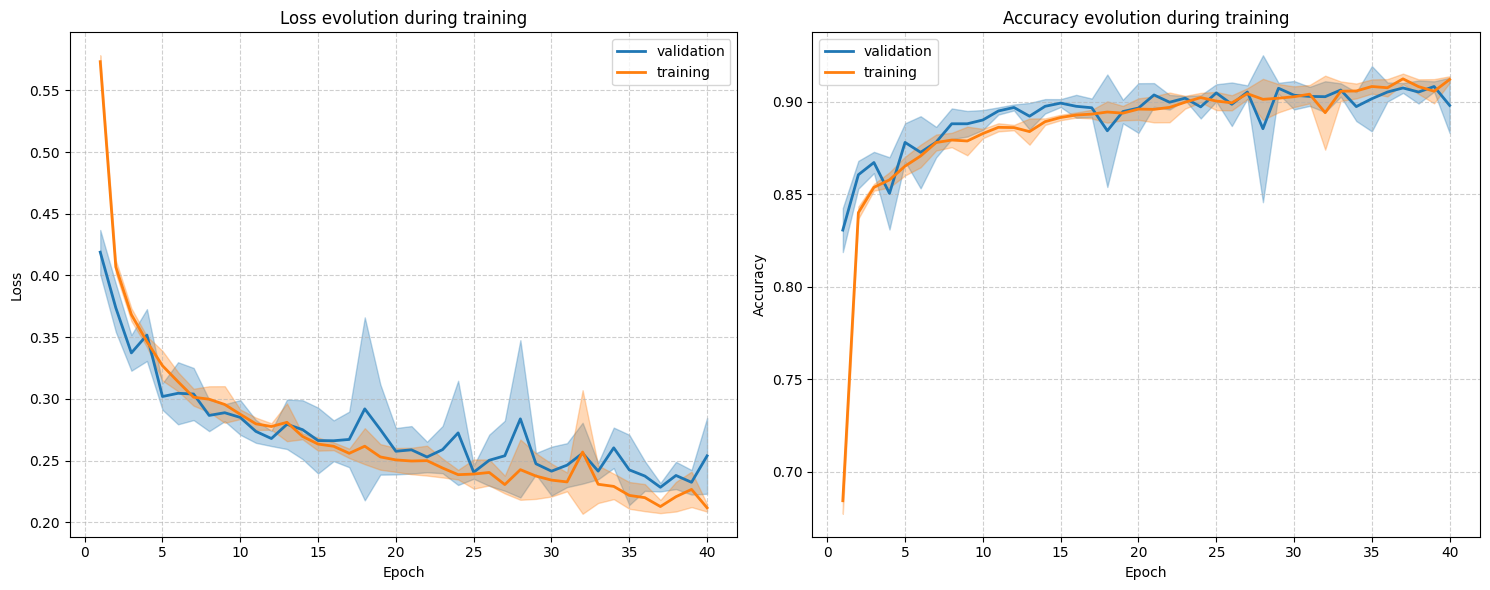

In [24]:
# --- NUEVO CÓDIGO PARA MANEJAR LONGITUDES DIFERENTES ---
# 1. Encontrar la longitud de la corrida más corta debido al early stopping
min_epochs = min([len(h['train_loss']) for h in all_histories])

# 2. Truncar todas las listas de historial a esa longitud mínima
train_loss_all = np.array([h['train_loss'][:min_epochs] for h in all_histories])
val_loss_all = np.array([h['val_loss'][:min_epochs] for h in all_histories])
train_acc_all = np.array([h['train_acc'][:min_epochs] for h in all_histories])
val_acc_all = np.array([h['val_acc'][:min_epochs] for h in all_histories])
# --- FIN DE LA CORRECCIÓN ---

# Calcular promedio (mean) y desviación estándar (std) a lo largo de las corridas (axis=0)
mean_train_loss = np.mean(train_loss_all, axis=0)
std_train_loss = np.std(train_loss_all, axis=0)

mean_val_loss = np.mean(val_loss_all, axis=0)
std_val_loss = np.std(val_loss_all, axis=0)

mean_train_acc = np.mean(train_acc_all, axis=0)
std_train_acc = np.std(train_acc_all, axis=0)

mean_val_acc = np.mean(val_acc_all, axis=0)
std_val_acc = np.std(val_acc_all, axis=0)

# El resto de tu código de graficación funcionará perfectamente con esto.
# Eje X para los gráficos (número de épocas)
epochs_range = range(1, len(mean_train_loss) + 1)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# (El resto de tu código para plt.plot y plt.fill_between va aquí y no necesita cambios)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
# Curva de validación
plt.plot(epochs_range, mean_val_loss, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.3)
# Curva de entrenamiento
plt.plot(epochs_range, mean_train_loss, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.3)
plt.title('Loss evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
# Curva de validación
plt.plot(epochs_range, mean_val_acc, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:blue', alpha=0.3)
# Curva de entrenamiento
plt.plot(epochs_range, mean_train_acc, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:orange', alpha=0.3)
plt.title('Accuracy evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [25]:
def get_test_predictions_and_labels(model, loader, device):
    model.eval()  # Poner el modelo en modo de evaluación
    all_labels = []
    all_preds = []

    with torch.no_grad(): # Desactivar el cálculo de gradientes
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # --- ¡Importante! ---
            # Ya que usas BCEWithLogitsLoss, la salida es un "logit".
            # Necesitamos aplicarle sigmoide y redondear para obtener una predicción (0 o 1).
            preds = torch.round(torch.sigmoid(outputs))

            # Mover a la CPU y guardar en las listas
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    # Concatenar todos los lotes en dos tensores grandes
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    return all_labels, all_preds

In [27]:
# --- 6. EVALUACIÓN FINAL EN EL CONJUNTO DE PRUEBA ---

print("\n--- Evaluando el modelo final en el conjunto de prueba ---")

# ¡Importante! Debes tener un 'test_loader' definido, similar a como definiste
# 'train_loader' y 'val_loader'.
# Por ejemplo:
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Usamos la función que definimos arriba.
# 'model' aquí es el modelo que se terminó de entrenar en la ÚLTIMA corrida (RUN 5)
all_labels, all_preds = get_test_predictions_and_labels(model, test_loader, device)

print("--- Evaluación de prueba completada ---")


# --- 7. CALCULAR MÉTRICAS (Tu código original) ---
# Ahora 'all_labels' y 'all_preds' SÍ existen.

print("\n--- Calculando Métricas Finales ---")
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy en prueba: {accuracy:.4f}")
print(f"Precision en prueba: {precision:.4f}")
print(f"Recall en prueba: {recall:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")


--- Evaluando el modelo final en el conjunto de prueba ---
--- Evaluación de prueba completada ---

--- Calculando Métricas Finales ---
Accuracy en prueba: 0.9127
Precision en prueba: 0.9384
Recall en prueba: 0.8840
F1-Score en prueba: 0.9104


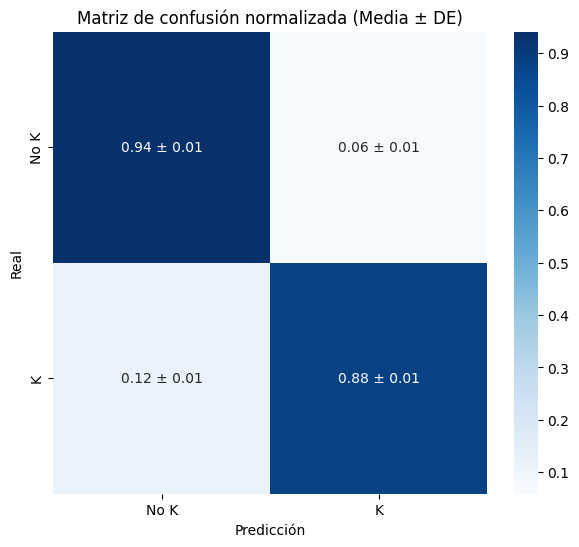

In [28]:
def plot_confusion_matrix_with_std(model, dataloader, device,
                                   n_bootstraps=1000,
                                   title="Matriz de confusión normalizada (Media ± DE)"):
    """
    Evalúa el modelo usando bootstrapping para calcular la media y DE
    de la matriz de confusión normalizada.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # 1. Obtener todas las predicciones y etiquetas una sola vez
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # 2. Realizar el bootstrapping
    bootstrapped_cms = []
    for _ in range(n_bootstraps):
        # Remuestrear los índices
        indices = resample(range(len(all_preds)))
        boot_labels = all_labels[indices]
        boot_preds = all_preds[indices]

        # Calcular la matriz de confusión para esta muestra
        cm = confusion_matrix(boot_labels, boot_preds, normalize='true')

        # Asegurarse de que la matriz sea 2x2 (en caso de que una muestra no tenga una clase)
        if cm.shape == (1, 1):
            if boot_labels[0] == 0:
                cm = np.array([[cm[0,0], 0], [0, 0]])
            else: # Si solo vio '1' y acertó '1':
                cm = np.array([[0, 0], [0, cm[0,0]]])

        bootstrapped_cms.append(cm)

    # 3. Calcular la media y la desviación estándar
    bootstrapped_cms = np.array(bootstrapped_cms)

    cm_mean = np.mean(bootstrapped_cms, axis=0) # Media a través de las muestras
    cm_std = np.std(bootstrapped_cms, axis=0)   # Desviación estándar a través de las muestras

    # 4. Crear las etiquetas de texto (anotaciones)
    annot_labels = np.empty_like(cm_mean, dtype=object)
    for i in range(cm_mean.shape[0]):
        for j in range(cm_mean.shape[1]):
            mean_val = cm_mean[i, j]
            std_val = cm_std[i, j]
            # FORMATO: "0.85 ± 0.02"
            annot_labels[i, j] = f"{mean_val:.2f} ± {std_val:.2f}"

    # 5. Graficar
    plt.figure(figsize=(7, 6)) # Un poco más grande para el texto

    # Usamos cm_mean para el COLOR
    # Usamos annot_labels para el TEXTO
    # Usamos fmt="" porque las etiquetas ya están formateadas
    sns.heatmap(cm_mean,
                annot=annot_labels,  # <--- Anotaciones personalizadas
                fmt="",                # <--- Formato vacío
                cmap="Blues",
                xticklabels=["No K", "K"],
                yticklabels=["No K", "K"])

    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Ejemplo de uso (AHORA LLAMA A LA NUEVA FUNCIÓN)
plot_confusion_matrix_with_std(model, test_loader, device)

# Detectar y Localizar

In [ ]:
class CRNN_DETECTAR_LOCALIZAR(nn.Module):
    """
    Implementación del modelo CRNN descrito en el diagrama y la tabla de hiperparámetros.
    """
    def __init__(self, in_channels=1, num_classes=2, Nf=64, N1=256, N2=128, p1=0.2, p2=0.5):
        super(CRNN_DETECTAR_LOCALIZAR, self).__init__()

        # --- Bloque Convolucional (Encoder) ---
        # Sigue el patrón: Conv -> Conv -> Pool
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(Nf, Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T -> T/2
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(Nf, 2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(2*Nf, 2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T/2 -> T/4
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(2*Nf, 4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(4*Nf, 4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T/4 -> T/8
        )

        # --- Bloque Recurrente ---
        self.dropout1 = nn.Dropout(p=p1)
        # La entrada al LSTM es el número de canales de salida del último bloque conv (4*Nf)
        self.blstm1 = nn.LSTM(input_size=4*Nf, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(p=p2)
        # La entrada al segundo LSTM es la salida del primero (2*N1 porque es bidireccional)
        self.blstm2 = nn.LSTM(input_size=2*N1, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)

        # --- Clasificador Final ---
        # Usa convoluciones 1x1 para clasificar cada punto de la secuencia T/8
        self.classifier = nn.Sequential(
            nn.Conv1d(2*N1, N2, kernel_size=1), # Salida del LSTM (2*N1) a N2
            nn.ReLU(),
            nn.Conv1d(N2, num_classes, kernel_size=1) # De N2 al número de clases (2 según el diagrama)
        )

    def forward(self, x):
        # x shape: (batch, channels, T) -> ej: (32, 1, 4000)

        # Encoder
        x = self.conv_block1(x) # -> (32, Nf, T/2)
        x = self.conv_block2(x) # -> (32, 2*Nf, T/4)
        x = self.conv_block3(x) # -> (32, 4*Nf, T/8), ej: (32, 256, 500)

        # Preparación para LSTMs
        # (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.permute(0, 2, 1) # -> (32, 500, 256)

        # Bloque Recurrente
        x = self.dropout1(x)
        x, _ = self.blstm1(x)
        x = self.dropout2(x)
        x, _ = self.blstm2(x)

        # Preparación para el clasificador
        # (batch, seq_len, channels) -> (batch, channels, seq_len)
        x = x.permute(0, 2, 1) # -> (32, 2*N1, 500), ej: (32, 512, 500)

        # Clasificador
        logits = self.classifier(x) # -> (32, num_classes, 500)

        return logits

In [ ]:
# df_detectar solo debe tener las columnas signal y existeK
df_detectar = df[['signal', 'labels']]

# División de datos: 80% entrenamiento, 10% validación, 10% prueba
# Primero, separamos el conjunto de entrenamiento del resto
train_df, temp_df = train_test_split(
    df_detectar, test_size=0.2, random_state=42
)
# Luego, dividimos el resto en validación y prueba
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42
)

print(f"\nTamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")



Tamaño del conjunto de entrenamiento: 10164
Tamaño del conjunto de validación: 1270
Tamaño del conjunto de prueba: 1271


In [ ]:
# This class is now set up for localization.
class SignalDataset(Dataset):
    """Custom Dataset for loading signals and localization labels."""
    def __init__(self, dataframe):
        self.signals = torch.tensor(np.array(dataframe['signal'].tolist()), dtype=torch.float32)
        # CHANGED: Switched from 'existeK' to 'labels'.
        # Assumes 'labels' column contains lists/arrays of the same length as the signal.
        self.labels = torch.tensor(np.array(dataframe['labels'].tolist()), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Add a "channel" dimension for the CNN, e.g., (4000) -> (1, 4000)
        signal = self.signals[idx].unsqueeze(0)
        # The label is now a vector, so we also add a channel dim, e.g., (4000) -> (1, 4000)
        label = self.labels[idx].unsqueeze(0)
        return signal, label

BATCH_SIZE = 64

# Crear instancias de Dataset
train_dataset = SignalDataset(train_df)
val_dataset = SignalDataset(val_df)
test_dataset = SignalDataset(test_df)

# Crear instancias de DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



# --- 4. UPDATED TRAINING AND EVALUATION FUNCTIONS ---

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Function to train the model for one epoch (for localization)."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0 # This will now count total points, not signals

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # The model output must have the same shape as the labels, e.g., (batch, 1, 4000)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Predictions are made for every point in the signal
        preds = (torch.sigmoid(outputs) > 0.5).float()
        # This correctly counts all matching points across the batch
        correct_predictions += (preds == labels).sum().item()
        # CHANGED: We now count every single point in the batch for accuracy calculation.
        total_samples += labels.numel()

    epoch_loss = running_loss / len(dataloader.dataset) # Loss is still per-signal
    epoch_acc = correct_predictions / total_samples      # Accuracy is now per-point
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Function to evaluate the model on a dataset (for localization)."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0 # This will now count total points, not signals

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            # CHANGED: We now count every single point in the batch for accuracy calculation.
            total_samples += labels.numel()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [ ]:
# --- 5. CICLO PRINCIPAL DE ENTRENAMIENTO (CON EARLY STOPPING) ---

# Hiperparámetros
EPOCHS = 30
LEARNING_RATE = 0.0001

# --- Early Stopping Parameters ---
patience = 10  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value

# Instanciar modelo, función de pérdida y optimizador
model_crnn = CRNN_DETECTAR_LOCALIZAR(
    in_channels=1,
    num_classes=2, # El diagrama termina con 2 clases
    Nf=64,
    N1=256,
    N2=128,
    p1=0.2,
    p2=0.5
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Almacenar historial para graficar
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\n--- Iniciando Entrenamiento ---")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Época {epoch+1}/{EPOCHS} | "
          f"Loss de entrenamiento: {train_loss:.4f} | Acc de entrenamiento: {train_acc:.4f} | "
          f"Loss de validación: {val_loss:.4f} | Acc de validación: {val_acc:.4f}")

    # --- Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optional: Save the best model here
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n--- Early stopping en la época {epoch+1} ---")
        break # Exit the training loop

print("--- Entrenamiento Finalizado ---")


--- Iniciando Entrenamiento ---


ValueError: Target size (torch.Size([64, 1, 4000])) must be the same as input size (torch.Size([64, 1]))

In [ ]:
# --- 6. EVALUACIÓN FINAL Y VISUALIZACIÓN ---

print("\n--- Evaluando en el conjunto de prueba ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().flatten())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy en prueba: {accuracy:.4f}")
print(f"Precision en prueba: {precision:.4f}")
print(f"Recall en prueba: {recall:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

# Graficar resultados del entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history['val_acc'], label='Precisión de Validación')
plt.title('Precisión a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# LOCALIZACION

In [29]:
class CRNN_DETECTAR_LOCALIZAR(nn.Module):
    """
    Implementación del modelo CRNN para LOCALIZACIÓN (secuencia a secuencia).
    """
    def __init__(self, in_channels=1, num_classes=1, Nf=64, N1=256, N2=128, p1=0.2, p2=0.5):
        super(CRNN_DETECTAR_LOCALIZAR, self).__init__()

        # --- Bloque Convolucional (Encoder) ---
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(Nf, Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T -> T/2 (2000)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(Nf, 2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(2*Nf, 2*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T/2 -> T/4 (1000)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(2*Nf, 4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(4*Nf, 4*Nf, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # T/4 -> T/8 (500)
        )

        # --- Bloque Recurrente ---
        self.dropout1 = nn.Dropout(p=p1)
        self.blstm1 = nn.LSTM(input_size=4*Nf, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(p=p2)
        self.blstm2 = nn.LSTM(input_size=2*N1, hidden_size=N1, num_layers=1, batch_first=True, bidirectional=True)

        # --- Clasificador Final ---
        # Usa convoluciones 1x1 para clasificar cada punto de la secuencia T/8
        self.classifier = nn.Sequential(
            nn.Conv1d(2*N1, N2, kernel_size=1), # Salida del LSTM (2*N1) a N2
            nn.ReLU(),
            nn.Conv1d(N2, num_classes, kernel_size=1) # De N2 al número de clases (AHORA 1)
        )

    def forward(self, x):
        # x shape: (batch, 1, 4000)

        # Encoder
        x = self.conv_block1(x) # -> (batch, 64, 2000)
        x = self.conv_block2(x) # -> (batch, 128, 1000)
        x = self.conv_block3(x) # -> (batch, 256, 500)

        # Preparación para LSTMs
        x = x.permute(0, 2, 1) # -> (batch, 500, 256)

        # Bloque Recurrente
        x = self.dropout1(x)
        x, _ = self.blstm1(x)
        x = self.dropout2(x)
        x, _ = self.blstm2(x) # -> (batch, 500, 512)

        # Preparación para el clasificador
        x = x.permute(0, 2, 1) # -> (batch, 512, 500)

        # Clasificador
        logits = self.classifier(x) # -> (batch, 1, 500)

        return logits

In [32]:
# (Celda iGNCh8oUeIJ1 corregida)

# 1. Seleccionamos las 3 columnas que necesitamos:
#    'signal' (entrada), 'labels' (salida), 'existeK' (para estratificar)
df_localizar = df[['signal', 'labels', 'existeK']]

# 2. División de datos 80/10/10 ESTRATIFICADA
# Ahora dividimos df_localizar, que SÍ tiene la columna 'labels'
train_df, temp_df = train_test_split(
    df_localizar,
    test_size=0.2,
    random_state=42,
    stratify=df_localizar['existeK'] # ¡Estratificamos!
)

# Dividimos el resto, también estratificado
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['existeK'] # ¡Estratificamos!
)

print(f"\nTamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}\n")

# Comprobamos el balanceo (opcional)
print("Balance de 'existeK' en train_df:")
print(train_df['existeK'].value_counts(normalize=True))


Tamaño del conjunto de entrenamiento: 10164
Tamaño del conjunto de validación: 1270
Tamaño del conjunto de prueba: 1271

Balance de 'existeK' en train_df:
existeK
1    0.501673
0    0.498327
Name: proportion, dtype: float64


In [33]:
import torch.nn.functional as F

# Esta clase está ahora configurada para localización.
class SignalDataset(Dataset):
    """Custom Dataset for loading signals and localization labels."""
    def __init__(self, dataframe):
        self.signals = torch.tensor(np.array(dataframe['signal'].tolist()), dtype=torch.float32)
        # Cargamos las etiquetas originales de 4000 puntos
        self.labels = torch.tensor(np.array(dataframe['labels'].tolist()), dtype=torch.float32)

        # Definimos las capas de pooling que usaremos en las etiquetas
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Señal de entrada: (1, 4000)
        signal = self.signals[idx].unsqueeze(0)

        # Etiqueta original: (4000)
        label_4000 = self.labels[idx]
        # Añadimos dimensiones para pooling: (1, 1, 4000)
        label_4000_pooled = label_4000.unsqueeze(0).unsqueeze(0)

        # Aplicamos el mismo pooling 3 veces
        label_500 = self.pool1(label_4000_pooled) # -> (1, 1, 2000)
        label_500 = self.pool2(label_500)       # -> (1, 1, 1000)
        label_500 = self.pool3(label_500)       # -> (1, 1, 500)

        # Quitamos la dimensión de canal, dejando (1, 500)
        label_out = label_500.squeeze(0)

        return signal, label_out # Devuelve (1, 4000) y (1, 500)

BATCH_SIZE = 64

# Crear instancias de Dataset
train_dataset = SignalDataset(train_df)
val_dataset = SignalDataset(val_df)
test_dataset = SignalDataset(test_df)

# Crear instancias de DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 4. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN (Actualizadas) ---
# (Tus funciones train_epoch y evaluate ya están casi correctas para esto,
# solo debemos asegurarnos de que la precisión se calcule sobre 500 puntos)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0 # Contará el total de puntos (batch_size * 500)

    for inputs, labels in dataloader:
        # inputs: [64, 1, 4000], labels: [64, 1, 500]
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # outputs: [64, 1, 500]
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.numel() # labels.numel() es 64*1*500 = 32000

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.numel()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [34]:
# (Celda EDhThwFafnGz)

# --- Cálculo de pos_weight para datos de localización (¡NUEVO!) ---
# Esto es crucial para que el modelo aprenda a detectar los eventos '1'
# que son menos frecuentes que los '0'.
print("Calculando peso para clases desbalanceadas...")
all_labels_list = train_df['labels'].tolist()
all_labels_tensor = torch.tensor(all_labels_list, dtype=torch.float32)
neg_count = (all_labels_tensor == 0).sum()
pos_count = (all_labels_tensor == 1).sum()

# Evitar división por cero si no hay ningún '1' (poco probable)
if pos_count > 0:
    pos_weight = neg_count / pos_count
else:
    pos_weight = torch.tensor(1.0) # Si no hay positivos, el peso es 1

print(f"Peso positivo (pos_weight) calculado: {pos_weight:.2f}")


# --- 5. CICLO PRINCIPAL DE ENTRENAMIENTO (CORREGIDO) ---

# Hiperparámetros
EPOCHS = 30
LEARNING_RATE = 0.0001 # El LR que usaste en el MLP parecía bueno

# --- Parámetros de Early Stopping ---
patience = 10
patience_counter = 0
best_val_loss = float('inf')

# --- Instanciar el modelo de LOCALIZACIÓN ---
# (Usando el num_classes=1 que definimos en el Paso 1)
model_loc = CRNN_DETECTAR_LOCALIZAR(
    in_channels=1,
    num_classes=1,
    Nf=64,
    N1=256,
    N2=128,
    p1=0.2,
    p2=0.5
).to(device)

# --- Usar el pos_weight en el Criterio ---
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

# --- Usar model_loc en el Optimizador ---
optimizer = optim.Adam(model_loc.parameters(), lr=LEARNING_RATE)

# Almacenar historial para graficar
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\n--- Iniciando Entrenamiento de Localización ---")
for epoch in range(EPOCHS):
    # --- Usar model_loc en el bucle ---
    train_loss, train_acc = train_epoch(model_loc, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_loc, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Época {epoch+1}/{EPOCHS} | "
          f"Loss de entrenamiento: {train_loss:.4f} | Acc de entrenamiento: {train_acc:.4f} | "
          f"Loss de validación: {val_loss:.4f} | Acc de validación: {val_acc:.4f}")

    # --- Lógica de Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Guardar el mejor modelo de localización
        torch.save(model_loc.state_dict(), 'best_model_localizacion.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n--- Early stopping en la época {epoch+1} ---")
        break

print("--- Entrenamiento de Localización Finalizado ---")

Calculando peso para clases desbalanceadas...


/tmp/ipython-input-2334601649.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  all_labels_tensor = torch.tensor(all_labels_list, dtype=torch.float32)


Peso positivo (pos_weight) calculado: 29.85

--- Iniciando Entrenamiento de Localización ---
Época 1/30 | Loss de entrenamiento: 0.5165 | Acc de entrenamiento: 0.7847 | Loss de validación: 0.3055 | Acc de validación: 0.8989
Época 2/30 | Loss de entrenamiento: 0.2213 | Acc de entrenamiento: 0.9440 | Loss de validación: 0.2408 | Acc de validación: 0.9181
Época 3/30 | Loss de entrenamiento: 0.1899 | Acc de entrenamiento: 0.9510 | Loss de validación: 0.1864 | Acc de validación: 0.9404
Época 4/30 | Loss de entrenamiento: 0.1719 | Acc de entrenamiento: 0.9562 | Loss de validación: 0.1503 | Acc de validación: 0.9566
Época 5/30 | Loss de entrenamiento: 0.1607 | Acc de entrenamiento: 0.9588 | Loss de validación: 0.1695 | Acc de validación: 0.9468
Época 6/30 | Loss de entrenamiento: 0.1541 | Acc de entrenamiento: 0.9599 | Loss de validación: 0.1558 | Acc de validación: 0.9482
Época 7/30 | Loss de entrenamiento: 0.1472 | Acc de entrenamiento: 0.9618 | Loss de validación: 0.1427 | Acc de validació


Cargando el mejor modelo (best_model_localizacion.pth) para evaluación...

--- Evaluando en el conjunto de prueba con el mejor modelo ---
Comparando 635500 etiquetas con 635500 predicciones.
Accuracy (por punto) en prueba: 0.9742
Precision (por punto) en prueba: 0.5718
Recall (por punto) en prueba: 0.9838
F1-Score (por punto) en prueba: 0.7232


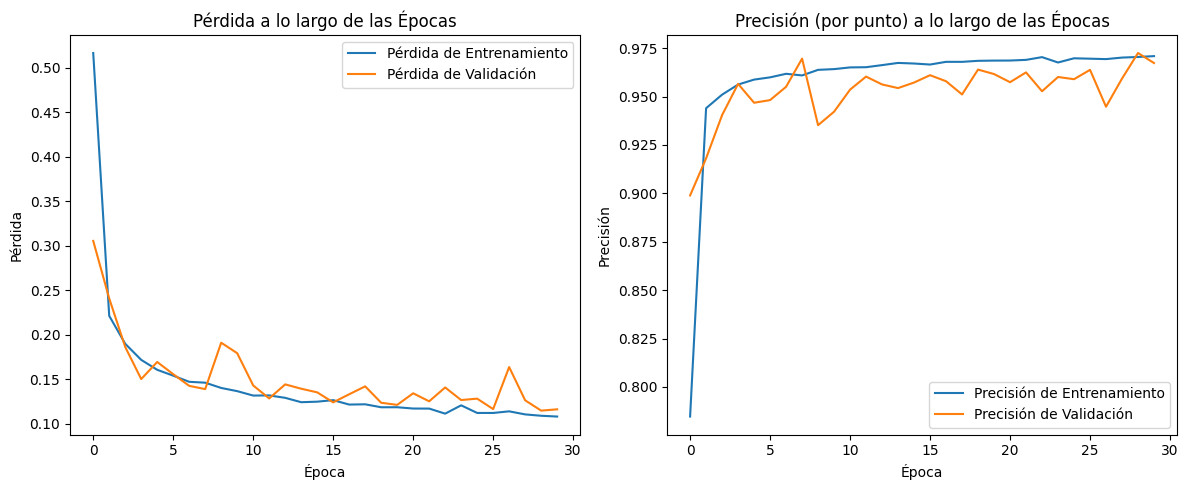


Generando Matriz de Confusión (por punto)...


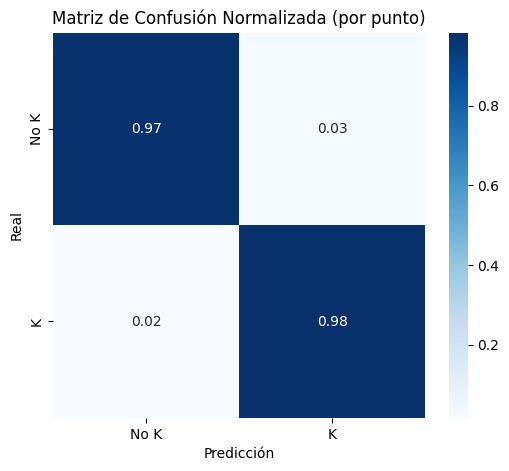

In [37]:
# --- 6. Cargar el mejor modelo guardado ---
print("\nCargando el mejor modelo (best_model_localizacion.pth) para evaluación...")
# Asegúrate de que model_loc esté definido (debería estarlo de la celda anterior)
model_loc.load_state_dict(torch.load('best_model_localizacion.pth'))


# --- 7. EVALUACIÓN FINAL Y VISUALIZACIÓN ---
print("\n--- Evaluando en el conjunto de prueba con el mejor modelo ---")
model_loc.eval()
all_preds_flat = []
all_labels_flat = []

with torch.no_grad():
    # Usamos test_loader (que tiene labels de 500 puntos)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_loc(inputs) # Salida (B, 1, 500)

        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Aplanamos ambas para la comparación punto a punto
        all_preds_flat.extend(preds.cpu().numpy().flatten())
        all_labels_flat.extend(labels.cpu().numpy().flatten())

# ¡Ahora ambos tendrán 635,500 puntos!
print(f"Comparando {len(all_labels_flat)} etiquetas con {len(all_preds_flat)} predicciones.")

# Calcular métricas (por punto)
accuracy = accuracy_score(all_labels_flat, all_preds_flat)
precision = precision_score(all_labels_flat, all_preds_flat)
recall = recall_score(all_labels_flat, all_preds_flat)
f1 = f1_score(all_labels_flat, all_preds_flat)

print(f"Accuracy (por punto) en prueba: {accuracy:.4f}")
print(f"Precision (por punto) en prueba: {precision:.4f}")
print(f"Recall (por punto) en prueba: {recall:.4f}")
print(f"F1-Score (por punto) en prueba: {f1:.4f}")

# Graficar resultados del entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history['val_acc'], label='Precisión de Validación')
plt.title('Precisión (por punto) a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves_localizacion.png')
plt.show()

# --- 8. Matriz de Confusión (por punto) ---
print("\nGenerando Matriz de Confusión (por punto)...")
cm = confusion_matrix(all_labels_flat, all_preds_flat, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No K", "K"], yticklabels=["No K", "K"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada (por punto)")
plt.savefig('confusion_matrix_localizacion.png')
plt.show()



In [38]:
# Importar 'islice' para tomar muestras fácilmente
from itertools import islice
import torch.nn.functional as F

def visualizar_localizacion(model, dataloader, original_df, device, num_samples=2):
    """
    Grafica la señal original, la verdad (ground truth) y las predicciones
    del modelo de localización.

    Args:
        model: El modelo de localización entrenado (model_loc).
        dataloader: El test_loader.
        original_df: El test_df (DataFrame) original, necesario para
                     obtener las etiquetas de 4000 puntos.
        device: 'cuda' o 'cpu'.
        num_samples: Cuántas muestras graficar.
    """
    model.eval()

    # Obtenemos el primer batch del dataloader
    # Como shuffle=False, este batch corresponde a las primeras N filas de original_df
    with torch.no_grad():
        signals_batch, pooled_labels_batch = next(iter(dataloader))
        signals_batch = signals_batch.to(device) # [B, 1, 4000]

        # 1. Obtener predicción (500 puntos) y re-escalarla a 4000
        logits_500 = model(signals_batch) # [B, 1, 500]

        #         # Hacemos Upsample x8 (500*8 = 4000)
        logits_4000 = F.interpolate(logits_500, scale_factor=8, mode='nearest') # [B, 1, 4000]

        # 2. Aplicar sigmoide y umbral (0.5) para obtener 0s y 1s
        preds_4000_batch = (torch.sigmoid(logits_4000) > 0.5).float().cpu().numpy()

        # 3. Obtener señales originales para plotear
        signals_4000_batch = signals_batch.cpu().numpy()

        # 4. Obtener las etiquetas VERDADERAS de 4000 puntos del dataframe original
        # (El dataloader solo tiene las de 500 que usamos para entrenar)
        batch_size_real = signals_batch.size(0)
        original_labels_4000_batch = np.array(original_df['labels'].tolist()[:batch_size_real])

    print(f"\n--- Mostrando {num_samples} ejemplos de localización (Azul=0, Rojo=1) ---")

    # 5. Graficar las primeras 'num_samples'
    for i in range(min(num_samples, len(signals_batch))):

        signal_to_plot = signals_4000_batch[i].squeeze() # (4000,)
        true_labels_to_plot = original_labels_4000_batch[i].squeeze() # (4000,)
        pred_labels_to_plot = preds_4000_batch[i].squeeze() # (4000,)

        time_axis = np.arange(4000)
        plt.figure(figsize=(16, 7))
        plt.suptitle(f"Muestra de Prueba #{i}", fontsize=16)

        # --- Subplot 1: Verdadera (Ground Truth) ---
        plt.subplot(2, 1, 1)
        # Usamos cmap='coolwarm' (azul a rojo) y vmin/vmax para forzar los colores
        plt.scatter(time_axis, signal_to_plot, c=true_labels_to_plot, cmap='coolwarm', s=5, vmin=0, vmax=1)
        plt.title("Etiqueta Verdadera (Ground Truth)")
        plt.ylabel("Amplitud (µV)")
        plt.grid(True, linestyle='--', alpha=0.5)

        # --- Subplot 2: Predicción del Modelo ---
        plt.subplot(2, 1, 2)
        plt.scatter(time_axis, signal_to_plot, c=pred_labels_to_plot, cmap='coolwarm', s=5, vmin=0, vmax=1)
        plt.title("Predicción del Modelo")
        plt.xlabel("Muestra (Sample index)")
        plt.ylabel("Amplitud (µV)")
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el supertítulo
        plt.show()


--- Mostrando 3 ejemplos de localización (Azul=0, Rojo=1) ---


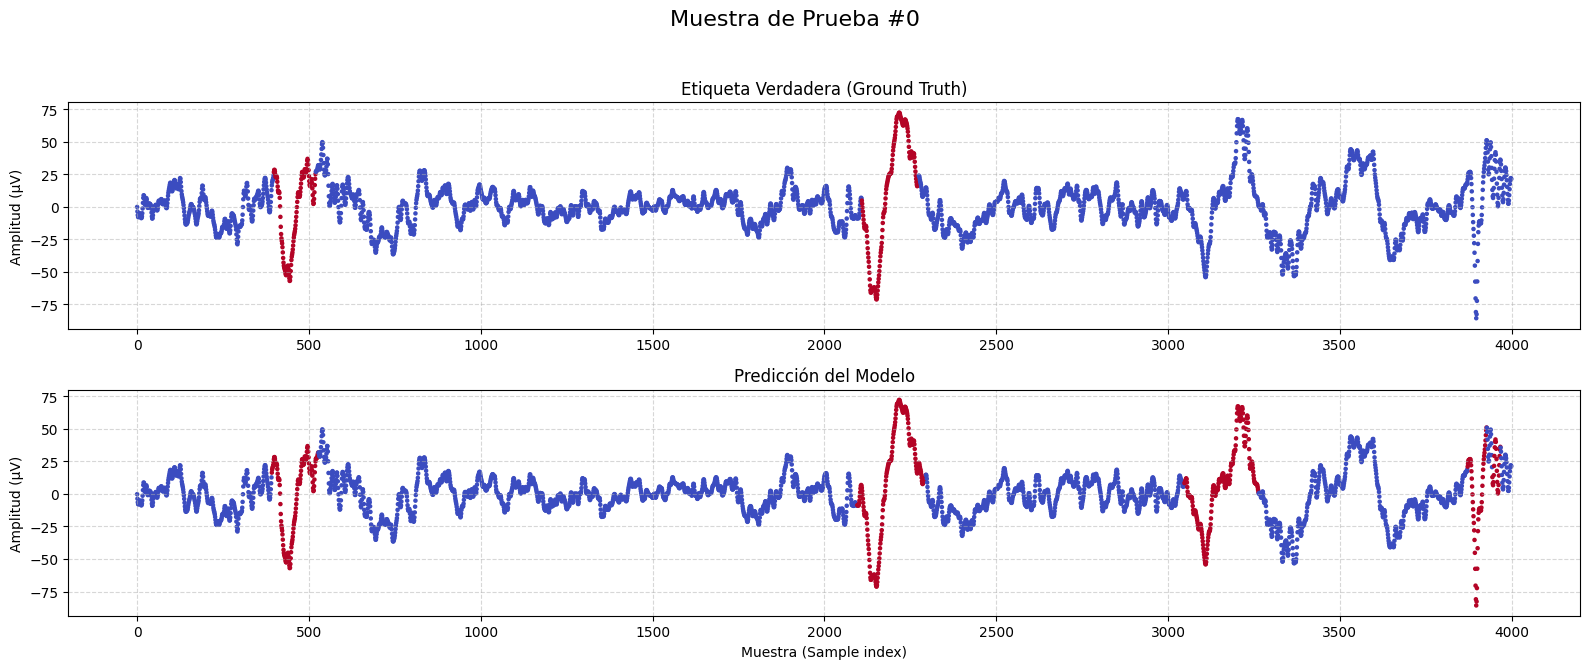

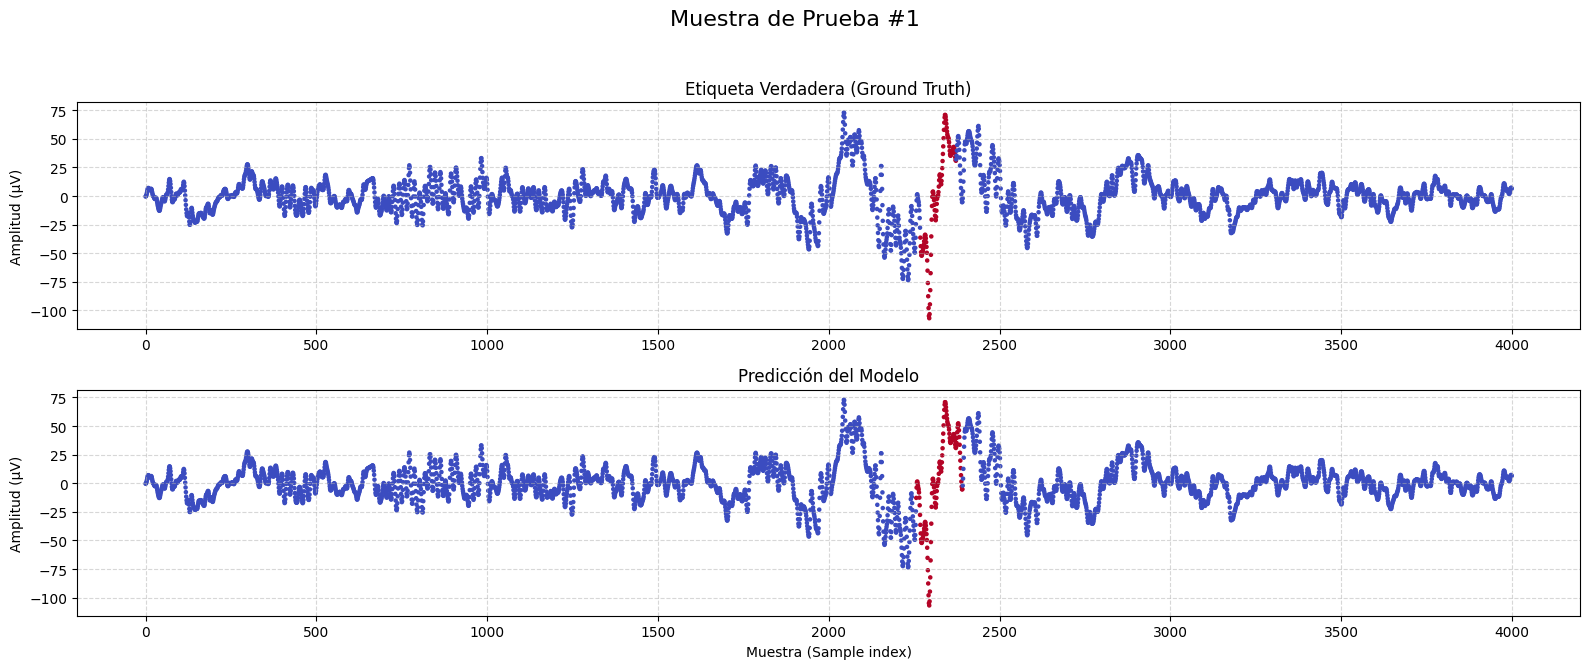

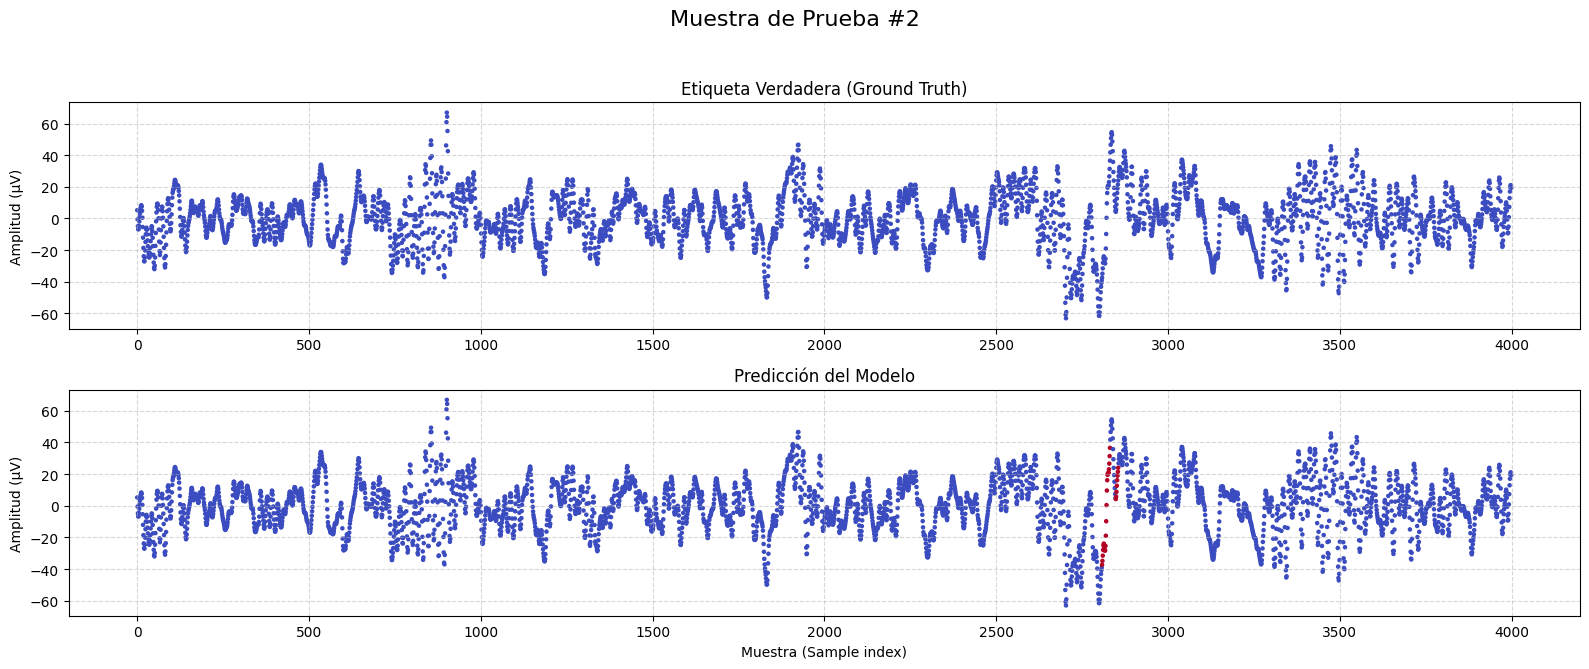

In [39]:
# Llamar a la función de visualización después de entrenar y evaluar
# (Asegúrate de que 'model_loc' es tu modelo entrenado y 'test_df' es tu DataFrame de prueba)
visualizar_localizacion(model_loc, test_loader, test_df, device, num_samples=3)

In [40]:
# --- 5. CICLO PRINCIPAL PARA MÚLTIPLES ENTRENAMIENTOS (LOCALIZACIÓN) ---

# Primero, calculamos el pos_weight UNA VEZ (como hicimos antes)
print("Calculando peso para clases desbalanceadas (pos_weight)...")
all_labels_500 = torch.cat([label for _, label in train_loader], dim=0)
neg_count = (all_labels_500 == 0).sum().item()
pos_count = (all_labels_500 == 1).sum().item()
pos_weight = (neg_count / pos_count) if pos_count > 0 else 1.0
print(f"Peso positivo (pos_weight) calculado: {pos_weight:.2f}")

# --- Hiperparámetros del Experimento ---
NUM_RUNS = 5
EPOCHS = 40 # Aumentado a 40 como en tus gráficos
LEARNING_RATE = 0.0001
PATIENCE = 10

all_histories = [] # Lista para guardar los historiales de cada corrida
global_best_val_loss = float('inf') # Para guardar el mejor modelo de todas las corridas
best_model_path = 'global_best_model_localizacion.pth'

for i in range(NUM_RUNS):
    print(f"\n--- Iniciando Corrida de Entrenamiento {i+1}/{NUM_RUNS} ---\n")

    # --- Reiniciar el modelo, criterio y optimizador en CADA corrida ---
    model_loc = CRNN_DETECTAR_LOCALIZAR(
        in_channels=1, num_classes=1, Nf=64, N1=256, N2=128, p1=0.2, p2=0.5
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    optimizer = optim.Adam(model_loc.parameters(), lr=LEARNING_RATE)

    # Variables de Early Stopping para ESTA corrida
    patience_counter = 0
    current_best_val_loss = float('inf')

    # Historial para ESTA corrida
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # --- Bucle de entrenamiento para una corrida ---
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model_loc, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model_loc, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Corrida {i+1}, Época {epoch+1}/{EPOCHS} | "
              f"Loss ent: {train_loss:.4f} | Acc ent: {train_acc:.4f} | "
              f"Loss val: {val_loss:.4f} | Acc val: {val_acc:.4f}")

        # Lógica de Early Stopping
        if val_loss < current_best_val_loss:
            current_best_val_loss = val_loss
            patience_counter = 0

            # Comprobar si este es el mejor modelo GLOBAL
            if val_loss < global_best_val_loss:
                global_best_val_loss = val_loss
                torch.save(model_loc.state_dict(), best_model_path)
                print(f"  -> Nuevo mejor modelo global guardado en época {epoch+1}")

        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f"--- Early stopping en la época {epoch+1} ---")
            break

    # Guardar el historial de esta corrida
    all_histories.append(history)

print(f"\n--- Todas las corridas de entrenamiento han finalizado ---")
print(f"El mejor modelo se ha guardado en: {best_model_path}")

Calculando peso para clases desbalanceadas (pos_weight)...
Peso positivo (pos_weight) calculado: 28.44

--- Iniciando Corrida de Entrenamiento 1/5 ---

Corrida 1, Época 1/40 | Loss ent: 0.5050 | Acc ent: 0.8069 | Loss val: 0.2390 | Acc val: 0.9247
  -> Nuevo mejor modelo global guardado en época 1
Corrida 1, Época 2/40 | Loss ent: 0.2122 | Acc ent: 0.9460 | Loss val: 0.1852 | Acc val: 0.9513
  -> Nuevo mejor modelo global guardado en época 2
Corrida 1, Época 3/40 | Loss ent: 0.1877 | Acc ent: 0.9512 | Loss val: 0.1691 | Acc val: 0.9539
  -> Nuevo mejor modelo global guardado en época 3
Corrida 1, Época 4/40 | Loss ent: 0.1678 | Acc ent: 0.9561 | Loss val: 0.1833 | Acc val: 0.9369
Corrida 1, Época 5/40 | Loss ent: 0.1601 | Acc ent: 0.9580 | Loss val: 0.1384 | Acc val: 0.9611
  -> Nuevo mejor modelo global guardado en época 5
Corrida 1, Época 6/40 | Loss ent: 0.1515 | Acc ent: 0.9605 | Loss val: 0.1380 | Acc val: 0.9609
  -> Nuevo mejor modelo global guardado en época 6
Corrida 1, Época 

Trazando hasta la época mínima de early stopping: 32


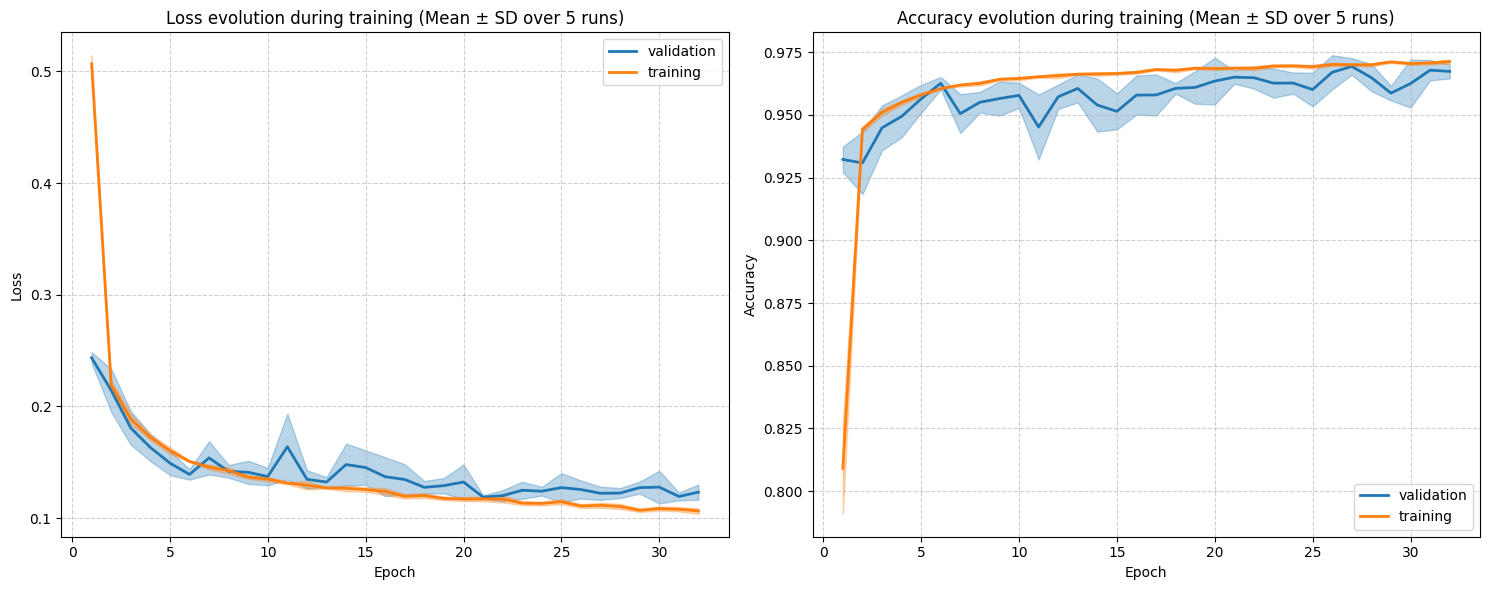

In [41]:
# --- MANEJO DE LONGITUDES DIFERENTES POR EARLY STOPPING ---
# 1. Encontrar la longitud de la corrida más corta
min_epochs = min([len(h['train_loss']) for h in all_histories])
print(f"Trazando hasta la época mínima de early stopping: {min_epochs}")

# 2. Truncar todas las listas de historial a esa longitud mínima
train_loss_all = np.array([h['train_loss'][:min_epochs] for h in all_histories])
val_loss_all = np.array([h['val_loss'][:min_epochs] for h in all_histories])
train_acc_all = np.array([h['train_acc'][:min_epochs] for h in all_histories])
val_acc_all = np.array([h['val_acc'][:min_epochs] for h in all_histories])
# --- FIN DE LA CORRECCIÓN ---

# Calcular promedio (mean) y desviación estándar (std)
mean_train_loss = np.mean(train_loss_all, axis=0)
std_train_loss = np.std(train_loss_all, axis=0)
mean_val_loss = np.mean(val_loss_all, axis=0)
std_val_loss = np.std(val_loss_all, axis=0)

mean_train_acc = np.mean(train_acc_all, axis=0)
std_train_acc = np.std(train_acc_all, axis=0)
mean_val_acc = np.mean(val_acc_all, axis=0)
std_val_acc = np.std(val_acc_all, axis=0)

# Eje X para los gráficos
epochs_range = range(1, min_epochs + 1)

# --- Graficar resultados ---
plt.figure(figsize=(15, 6))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mean_val_loss, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.3)
plt.plot(epochs_range, mean_train_loss, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.3)
plt.title('Loss evolution during training (Mean ± SD over 5 runs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, mean_val_acc, label='validation', color='tab:blue', lw=2)
plt.fill_between(epochs_range, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:blue', alpha=0.3)
plt.plot(epochs_range, mean_train_acc, label='training', color='tab:orange', lw=2)
plt.fill_between(epochs_range, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:orange', alpha=0.3)
plt.title('Accuracy evolution during training (Mean ± SD over 5 runs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('training_curves_localizacion_5runs.png')
plt.show()

Cargando global_best_model_localizacion.pth para la matriz de confusión...


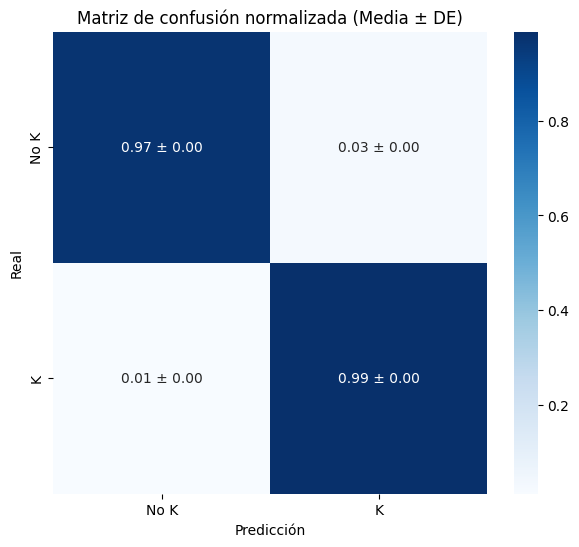


--- Mostrando 3 ejemplos de localización (Azul=0, Rojo=1) ---


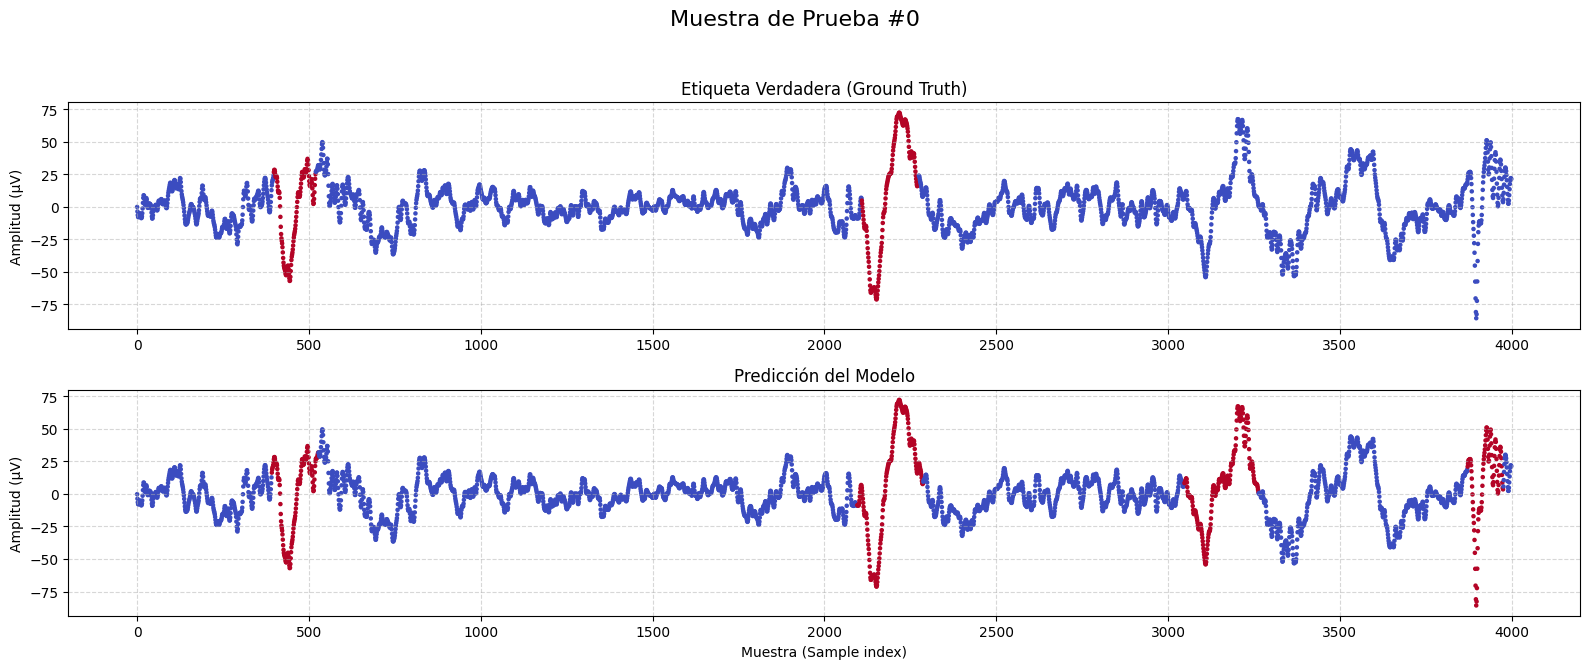

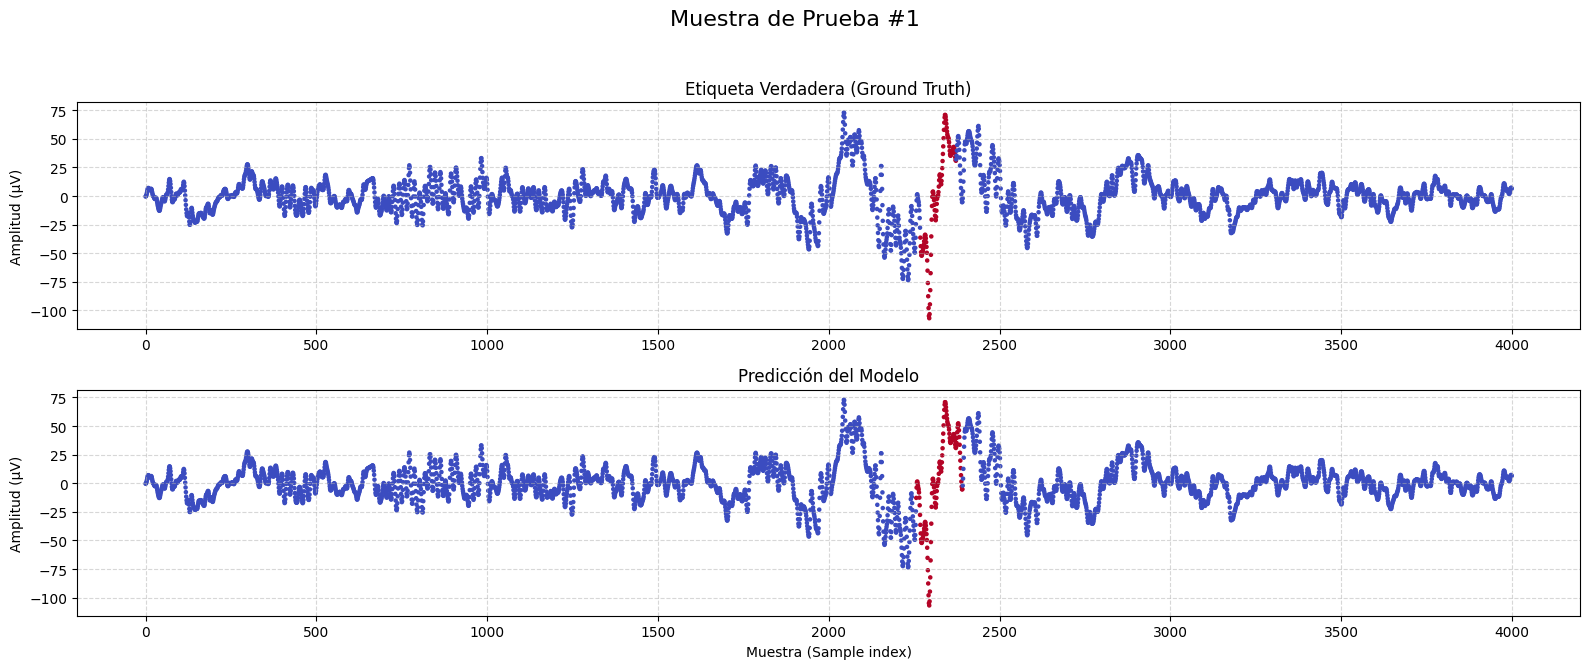

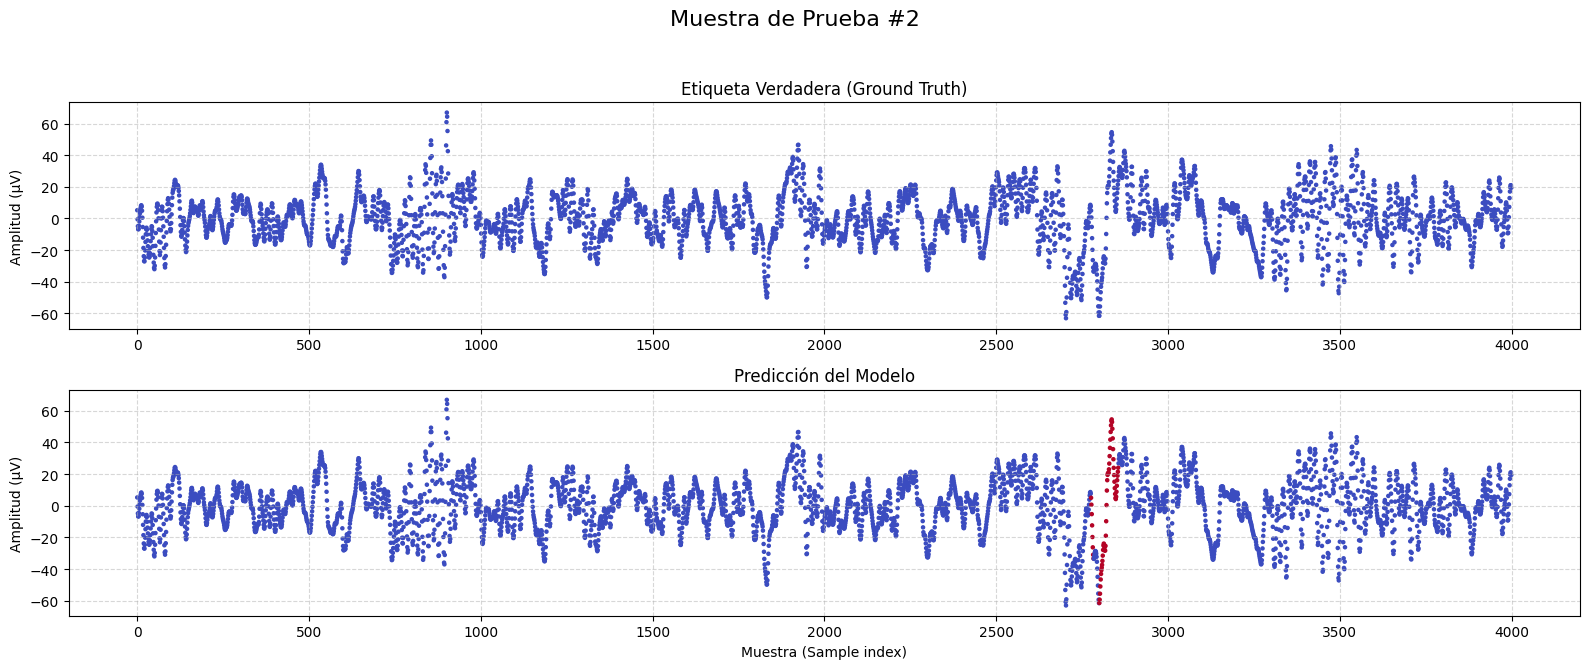

In [42]:
# --- EVALUACIÓN DEL MEJOR MODELO CON BOOTSTRAPPING ---

# 1. Instanciar un nuevo modelo de localización
best_model = CRNN_DETECTAR_LOCALIZAR(
    in_channels=1, num_classes=1, Nf=64, N1=256, N2=128, p1=0.2, p2=0.5
).to(device)

# 2. Cargar los pesos del mejor modelo guardado en el bucle anterior
print(f"Cargando {best_model_path} para la matriz de confusión...")
best_model.load_state_dict(torch.load(best_model_path))


# 3. Esta función realiza el bootstrapping para obtener la Media ± DE
plot_confusion_matrix_with_std(best_model, test_loader, device)

# 4. (Opcional) También podemos llamar a la función de visualización de antes
visualizar_localizacion(best_model, test_loader, test_df, device, num_samples=3)